In [1]:
import numpy as np
import matplotlib.pyplot as plt
plt.style.use('rose-pine')
from typing import Iterable
from tqdm import tqdm


In [2]:
L = .04
n_c = 1
x = np.linspace(0,L, 2000)
lxc = .0022
dx = x[1] - x[0]

In [3]:
def generate_gaussian_perturbation(lcx : float) -> np.ndarray:
    """|
    generate_gaussian_perturbation generate a gaussian perturbation of density field expected to be linear

    Parameters
    ----------
    lcx : float
        radial correlation length if the turbulence

    Returns
    -------
    np.ndarray
        gaussian perturbated field of density
    """    
    phase = np.random.uniform(0, 2 * np.pi, 2000)
    rw = 2 * np.pi * np.fft.fftfreq(len(x), dx)
    
    gaussian_spectrum = np.exp(-rw**2 * lcx**2 / 8 + 1j * phase)
    return np.fft.ifft(np.fft.ifftshift(gaussian_spectrum))


In [4]:
def generate_gaussian_samples(lcx : float, n_samples : int) -> np.ndarray:
    """
    generate_gaussian_samples generate a set of gaussian perturbations of density field expected to be linear

    Parameters
    ----------
    lcx : float
        radial correlation length if the turbulence
    n_samples : int
        number of samples to generate

    Returns
    -------
    np.ndarray
        gaussian perturbated field of density
    """    
    return np.array([generate_gaussian_perturbation(lcx) for _ in range(n_samples)])

In [5]:
gaussian_distribution = generate_gaussian_samples(lxc, 4000)

In [6]:
np.std(gaussian_distribution.real, axis=0).shape

(2000,)

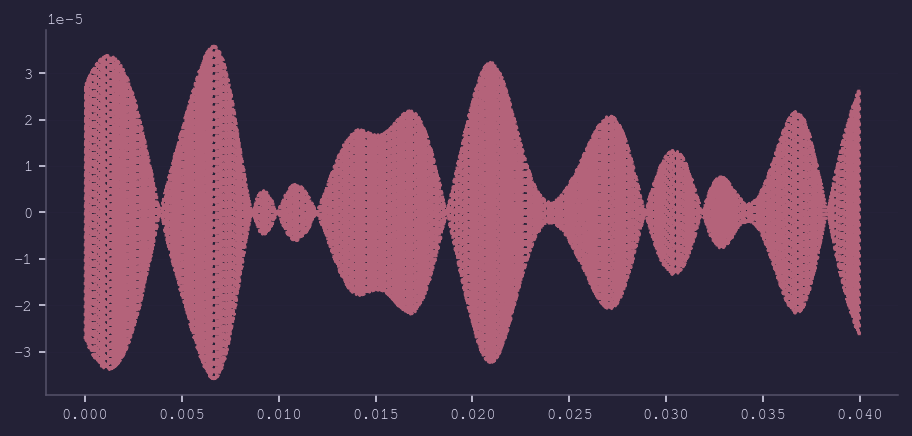

In [56]:
fig, ax = plt.subplots(1,1)
dn = gaussian_distribution.real
ax.plot(x, np.mean(gaussian_distribution.real, axis=0), label='$\delta n$', ls = ':')


In [8]:
def sampling_decay(dn_distribution : np.ndarray) :
    
    td = map(lambda dn : 2 / 3e8 * np.trapz(1 / np.sqrt(1 - x/L -  dn / n_c), dx=dx), dn_distribution)
    return  list(td)


In [58]:
def ampli_delay(dn_distribution : np.ndarray, ampli : Iterable) :
    rms_td = []
    rms_n = []
    for amp in tqdm(ampli):
        dn = dn_distribution * amp
        td = np.array(sampling_decay(dn - dn.mean()))
        np.nan_to_num(td, copy=False, nan=0.0, posinf=0.0, neginf=0.0)
        mask = td > 0
        rms_td.append(np.std(td[mask]))
        rms_n.append(np.std(dn[mask]/ n_c))
    return np.array(rms_td), np.array(rms_n)

In [59]:
ampli = np.logspace(-4,3, 100)
rms_td, rms_n = ampli_delay(gaussian_distribution, ampli)

100%|██████████| 100/100 [01:02<00:00,  1.59it/s]


In [71]:
dt_theo =  L / 3e8 * np.sqrt(L / lxc) * rms_n ** .5 / 4

(1e-05, 1)

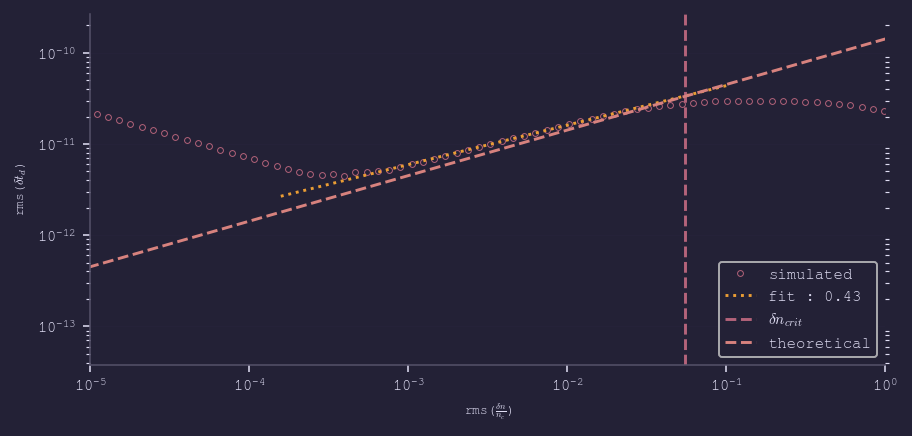

In [79]:
fig, ax = plt.subplots(1,1)

x1 = np.logspace(-3.8,-1, 1000)
mask = (rms_n > 5e-4) & (rms_n< 1e-2)
logx = np.log(rms_n[mask])
logy = np.log(rms_td[mask])

coeffs = np.polyfit(logx,logy,deg=1)
yfit =  np.exp(coeffs[1]) * x1 ** coeffs[0]


ax.loglog(rms_n, rms_td, lw = 0, marker = 'o', label='simulated', mfc = 'none', mew = .5, ms = 3, alpha=1)
ax.loglog(x1, yfit, label=f'fit : {coeffs[0]:.2f}', ls = ':')
ax.axvline(n_c * lxc / L, label='$\\delta n_{crit}$', ls = '--')
ax.loglog(rms_n, dt_theo  , label='theoretical', ls = '--')
ax.set_xlabel('rms($\\frac{\delta n}{n_c}$)')
ax.set_ylabel('rms($\delta t_d$)')
ax.legend()
ax.set_xlim(1e-5, 1)